In [1]:
import requests
import time
import pandas as pd
import surprise as surprise
import numpy as np
from decimal import Decimal
from scipy.sparse import coo_matrix
from scipy import sparse
from tqdm import tqdm

In [2]:
users_ratings = pd.read_csv("ratings.csv")
print(users_ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
users_ratings = users_ratings.drop('timestamp', axis=1)
# movie_data = pd.merge(ratings_data, movie_names, on='movieId')
users_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
user_movie_rating = users_ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# оценка пользователя 1 для фильма 47
user_movie_rating[47][1]

5.0

In [11]:
user_movie_rating.fillna(0.0, inplace=True)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Может быть, заполнение пробелов нулями было не очень хорошей идеей. Чтобы сделать предсказания лучше, вы можете выполнить так называемое вменение. Оба метода называются вменением. Это решение упрощает работу, но вы можете добиться еще лучших результатов с помощью базовых предикторов, о которых мы поговорим в ближайшее время. В следующем листинге мы заполняем ячейки средними оценками.

Что делать с данными, которые нам неизвестны? В рассмотренном ранее
примере было всего несколько неизвестных, но часто возникает ситуация,
когда заполнен только 1 % клеток в матрице оценок. Надо что-то с этим де-
лать. Есть два распространенных способа подойти к этой проблеме:
1. вы можете вычислить среднее значение каждого элемента (или пользователя) и заполнить средним значением нулевые ячейки матрицы;
2. вы можете нормализовать каждую строку так, чтобы ноль оказался средним значением.

Оба метода называются вменением. Это решение упрощает работу, но вы
можете добиться еще лучших результатов с помощью базовых предикторов,
о которых мы поговорим в ближайшее время. В следующем листинге мы за-
полняем ячейки средними оценками.

Воспользуемся вменением 2

## Базисные предикты
базисным предиктором, который упрощает добавление значений в пустые ячейки
матрицы. Хотя их можно использовать в качестве рекомендательный систе-
мы, здесь это будет способ сделать матричную факторизацию лучше.

Кроме типов элементов и вкусов пользователей, есть и другие стоящие
упоминания аспекты. Если фильм считается хорошим, то средняя оценка это-
го фильма, вероятно, немного выше средней для всех фильмов, и наоборот,
оценка плохого фильма ниже средней. Если у вас есть такая информация, вы
можете добавить элементу чуть более высокую оценку. В то же время неко-
торые пользователи критикуют фильмы больше, чем другие (я же не сказал
«сварливые старикашки»), или, наоборот, более позитивны. Элементы с оцен-
ками выше или ниже среднего уровня имеют, так сказать, отклонение. То же
самое относится и к пользователям. Можно сказать, что пользователи имеют
отклонение по сравнению с глобальным средним.
Если бы вы могли извлечь значения отклонений элементов и пользовате-
лей, то можно было бы рассчитать базис для прогнозов, что будет лучше, чем
среднее, при заполнении пустых ячеек в матрице оценок. Используя эти от-
клонения, вы можете создавать базисные предикторы. Базисный предиктор –
это сумма глобального среднего плюс отклонение элемента плюс отклонение
пользователя. С точки зрения математики это выглядит вот так:

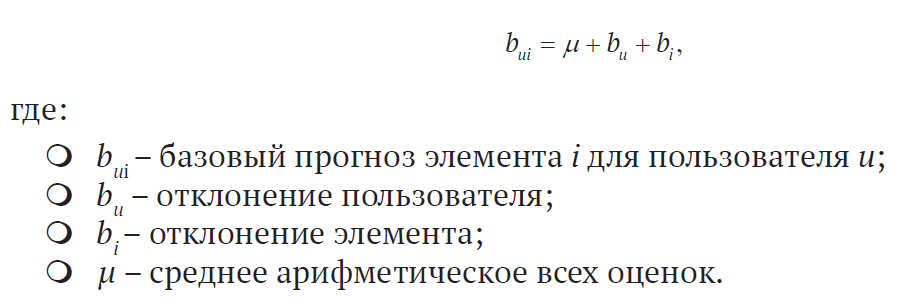

In [12]:
## Вычисление предиктов
global_mean = user_movie_rating[user_movie_rating>0].mean().mean()
print(global_mean)
user_movie_rating_minus_mean = user_movie_rating[user_movie_rating>0]-global_mean
user_bias = user_movie_rating_minus_mean.T.mean()
print(user_bias)
item_bias = user_movie_rating_minus_mean.apply(lambda r: r - user_bias).mean()
print(item_bias)

3.2624482748109656
userId
1      1.103931
2      0.685828
3     -0.826551
4      0.293107
5      0.373915
         ...   
606    0.394951
607    0.523648
608   -0.128273
609    0.007822
610    0.426108
Length: 610, dtype: float64
movieId
1         0.312167
2        -0.053158
3        -0.234798
4        -1.096045
5        -0.522626
            ...   
193581    0.294776
193583   -0.205224
193585   -0.205224
193587   -0.205224
193609    0.372024
Length: 9724, dtype: float64


In [14]:
# заменяем нули предиктами
for rowIndex, row in tqdm(user_movie_rating.iterrows()): #iterate over rows
    for columnIndex, value in row.items():
        if (value == 0):
            user_movie_rating.loc[rowIndex][columnIndex]=global_mean +user_bias[rowIndex]+item_bias[columnIndex]
print(user_movie_rating)

610it [06:28,  1.57it/s]

movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        4.000000  4.313221  4.000000  3.270335  3.843753  4.000000  3.965652   
2        4.260443  3.895118  3.713478  2.852231  3.425650  4.326737  3.547548   
3        2.748064  2.382739  2.201100  1.339853  1.913271  2.814358  2.035170   
4        3.867722  3.502397  3.320758  2.459511  3.032930  3.934016  3.154828   
5        4.000000  3.583205  3.401566  2.540319  3.113738  4.014824  3.235636   
...           ...       ...       ...       ...       ...       ...       ...   
606      2.500000  3.604241  3.422601  2.561354  3.134773  4.035860  2.500000   
607      4.000000  3.732938  3.551299  2.690052  3.263470  4.164557  3.385369   
608      2.500000  2.000000  2.000000  2.038131  2.611550  3.512636  2.733448   
609      3.000000  3.217112  3.035473  2.174226  2.747644  3.648731  2.869543   
610      5.000000  3.635398 

In [34]:
from numpy import linalg
U, Sigma, Vt = linalg.svd(user_movie_rating)

In [39]:
# print(Sigma)
print(Sigma.sum())
# 90%
print(Sigma.sum()*0.9)
print(Sigma[:300].sum())

14032.238225097439
12629.014402587694
12890.103191904567


In [40]:
k=300

In [48]:
def rank_k2(k):
    U_reduced= np.mat(U[:,:k])
    Vt_reduced = np.mat(Vt[:k,:])
    Sigma_reduced = Sigma_reduced = np.eye(k)*Sigma[:k]
    Sigma_sqrt = np.sqrt(Sigma_reduced)
    return U_reduced*Sigma_sqrt, Sigma_sqrt*Vt_reduced
U_reduced, Vt_reduced = rank_k2(4)
predicted_user_movie_rating = U_reduced * Vt_reduced
print(predicted_user_movie_rating)

[[4.63386331 4.31456242 4.16118239 ... 4.16204079 4.16204079 4.73896909]
 [4.23666034 3.89693703 3.71692381 ... 3.74287318 3.74287318 4.3201915 ]
 [2.78304957 2.38122351 2.14667357 ... 2.22885734 2.22885734 2.80580186]
 ...
 [3.63328316 3.0963976  2.82321965 ... 2.93381557 2.93381557 3.51592362]
 [3.5920589  3.21688039 3.02048589 ... 3.06513224 3.06513224 3.64188958]
 [4.29510655 3.6066629  3.55410678 ... 3.4808043  3.4808043  4.06058414]]


In [49]:
# оценка пользователя 1 для фильма 47
predicted_user_movie_rating[47,1]

3.9782898770532205

In [51]:
type(predicted_user_movie_rating)

numpy.matrix

In [52]:
np.savetxt("SVD_predicted_user_movie_rating.csv", predicted_user_movie_rating, delimiter=",")

In [54]:
my_data = np.genfromtxt('SVD_predicted_user_movie_rating.csv', delimiter=',')

In [56]:
my_data[47,1]

3.9782898770532205